In [490]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import special
import copy
from scipy import signal as sp
from scipy.linalg import lstsq
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [492]:
def generate_digital_signal(length):
    return np.random.choice([-1, 1], size=length)

In [494]:
def Jakes_filter(f_max, Ts, N):
    L = N//2
    n = np.arange(1, L + 1)
    J_pos = special.jv(0.25, 2 * np.pi * f_max * n * Ts) / (n ** 0.25)
    J_neg = np.flip(J_pos)
    J_0 = 1.468813 * (f_max * Ts) ** 0.25
    J = np.concatenate((J_neg, [J_0], J_pos))
    n = np.arange(0, N + 1)
    hamm = 0.54 - 0.46 * np.cos(2 * np.pi * n / N)
    hw = J * hamm
    hw = hw / np.sqrt(np.sum(np.abs(hw) ** 2))
    return hw

# Generate Rayleigh envelope
def generate_rayleigh_envelope(signal_length, velocity, carrier_frequency):
    c = 3e8  # Speed of light in m/s
    fd = velocity * carrier_frequency / c
    Fs = 10000  # Sampling frequency
    N = 512
    Ts = 1 / Fs
    h = Jakes_filter(fd, Ts, N)
    x = np.random.randn(signal_length + 1000)
    y = np.convolve(x, h, 'valid')
    return y

# Apply Rayleigh fading
def apply_rayleigh_fading(signal, y):
    signal2 = copy.deepcopy(signal)
    for i in range(len(signal2)):
        signal2[i] *= y[i]
    return signal2, y[:len(signal2)]


In [496]:
# Add AWGN noise
def add_awgn_noise(signal, snr_db):
    snr = 10 ** (snr_db / 10)
    signal_power = np.mean(signal ** 2)
    noise_power = signal_power / snr
    noise = np.sqrt(noise_power) * np.random.normal(size=signal.shape)
    return signal + noise


In [540]:
# Estimate channel using least squares
def estimate_h(x_known, y):
    return lstsq(x_known.reshape(-1, 1), y)[0]

In [542]:
# Apply channel estimation
def apply_channel_estimation(signal, h_estimates):
    signal2 = copy.deepcopy(signal)
    packet_size = len(signal2) // len(h_estimates)
    for i in range(len(h_estimates)):
        start_idx = i * packet_size
        end_idx = start_idx + packet_size
        signal2[start_idx:end_idx] /= h_estimates[i]
    return signal2

# Digitize the signal
def digitize(signal):
    signal2 = copy.deepcopy(signal)
    for i in range(len(signal2)):
        if signal2[i]>0:
            signal2[i] = 1
        else:
            signal2[i] = -1
    return signal2

In [544]:
def calculate_header_mse(original_signal, estimated_signal, packet_size, header_size):
    mse_values = []
    for i in range(0, len(original_signal), packet_size):
        original_header = original_signal[i:i+header_size]
        estimated_header = estimated_signal[i:i+header_size]
        mse = mean_squared_error(original_header, estimated_header)
        mse_values.append(mse)
    return np.mean(mse_values)


In [546]:
def calculate_non_header_ber(original_signal, estimated_signal, packet_size, header_size):
    correct = 0
    total = 0
    for i in range(0, len(original_signal), packet_size):
        original_non_header = original_signal[i+header_size:i+packet_size]
        estimated_non_header = estimated_signal[i+header_size:i+packet_size]
        correct += np.sum(original_non_header * estimated_non_header > 0)
        total += len(original_non_header)
    return 1 - (correct / total)

In [548]:
def find_coherence_time(signal_length, num_packets, snr_db, packet_sizes, velocity, carrier_frequency):
    correlation_values = []
    for packet_size in packet_sizes:
        original_signal = generate_digital_signal(signal_length)
        rayleigh_envelope = generate_rayleigh_envelope(signal_length, velocity, carrier_frequency)
        faded_signal, actual_h = apply_rayleigh_fading(original_signal, rayleigh_envelope)
        noisy_signal = add_awgn_noise(faded_signal, snr_db)
        
        h_estimates = []
        for i in range(0, signal_length, packet_size):
            h_estimate = estimate_h(original_signal[i:i+packet_size], noisy_signal[i:i+packet_size])
            h_estimates.extend([h_estimate] * packet_size)
        
         # Trim arrays to match lengths
        min_length = min(len(actual_h), len(h_estimates))
        actual_h_trimmed = actual_h[:min_length]
        h_estimates_trimmed = h_estimates[:min_length]
        
        correlation = np.corrcoef(actual_h_trimmed, h_estimates_trimmed)[0, 1]
        correlation_values.append(correlation)
    
    plt.figure(figsize=(10, 6))
    plt.plot(packet_sizes, correlation_values, marker='o')
    plt.title('Channel Correlation vs Packet Size')
    plt.xlabel('Packet Size (samples)')
    plt.ylabel('Correlation')
    plt.grid(True)
    plt.show()
    
    # Find the packet size where correlation drops significantly
    coherence_time = packet_sizes[np.argmax(np.diff(correlation_values) < -0.05)]
    return coherence_time

In [550]:
# Parameters
packet_size = 60
num_packets = 100
signal_length = packet_size*num_packets
header_size = 10
snr_db = 10 * np.log10(10) #10*np.log10(snr)
velocity = 1.3 #m/s
carrier_frequency = 2e9 #Hz

In [552]:
def channel_estimation(packet_size, num_packets, header_size, snr_db, velocity, carrier_frequency):
    signal_length = packet_size * num_packets
    
    original_signal = generate_digital_signal(signal_length)
    rayleigh_envelope = generate_rayleigh_envelope(signal_length, velocity, carrier_frequency)
    faded_signal, actual_h = apply_rayleigh_fading(original_signal, rayleigh_envelope)
    noisy_signal = add_awgn_noise(faded_signal, snr_db)
    
    packets = [original_signal[i:i + packet_size] for i in range(0, signal_length, packet_size)]
    noisy_packets = [noisy_signal[i:i + packet_size] for i in range(0, signal_length, packet_size)]
    h_estimates = [estimate_h(packet[:header_size], noisy_packet[:header_size]) for packet, noisy_packet in zip(packets, noisy_packets)]
    estimated_signal = apply_channel_estimation(noisy_signal, h_estimates)
    
    estimated_signal = digitize(estimated_signal)
    
    return original_signal, noisy_signal, estimated_signal, faded_signal, h_estimates, actual_h

In [554]:
# Run the updated process
original_x, y, estimated_x, just_h_y, h_estimates, actual_h = channel_estimation(packet_size, num_packets, header_size, snr_db, velocity, carrier_frequency)

In [556]:
#Compute MSE for only the header
header_mse = calculate_header_mse(original_x, estimated_x, packet_size, header_size)
print(f"Header MSE: {header_mse}")

#Compute BER for only the non-header part
non_header_ber = calculate_non_header_ber(original_x, estimated_x, packet_size, header_size)
print(f"Non-header BER: {non_header_ber}")

Header MSE: 1.276
Non-header BER: 0.4234


In [558]:
#Find coherence time
packet_sizes = np.arange(2, 513, 32)
coherence_time = find_coherence_time(signal_length, num_packets, snr_db, packet_sizes, velocity, carrier_frequency)

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 6000 and the array at index 1 has size 1

Text(0, 0.5, 'BER/MSE values')

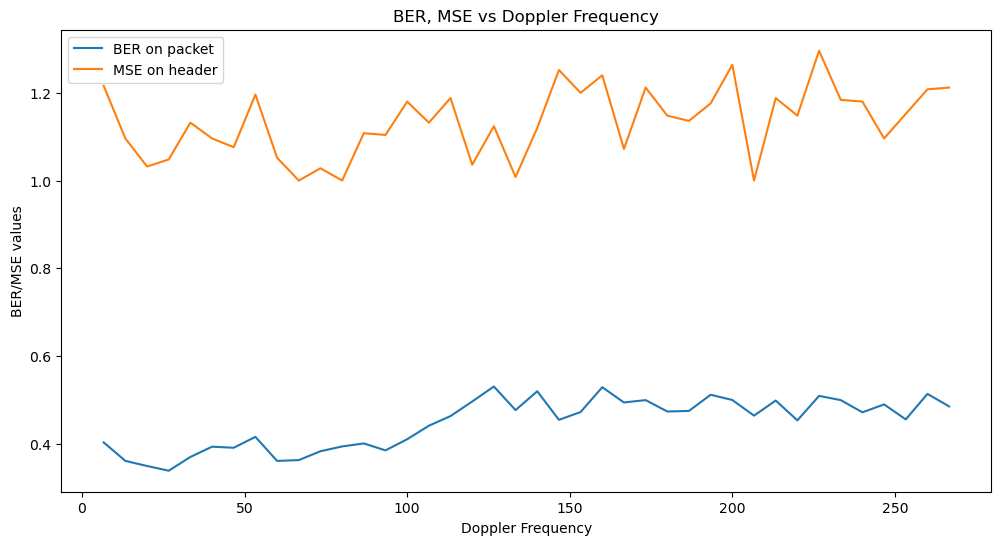

In [560]:
#Plotting BER vs frequency
ber_array = []
mse_array = []
v_range = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40])
for i in v_range:
    original_x, y, estimated_x, just_h_y, h_estimates, actual_h = channel_estimation(packet_size, num_packets, header_size, snr_db, i, carrier_frequency)
    non_header_ber = calculate_non_header_ber(original_x, estimated_x, packet_size, header_size)
    ber_array.append(non_header_ber)
    header_mse = calculate_header_mse(original_x, estimated_x, packet_size, header_size)
    mse_array.append(header_mse)
plt.figure(figsize = (12,6))
plt.plot(v_range*carrier_frequency/3e8, ber_array, label = "BER on packet")
plt.plot(v_range*carrier_frequency/3e8, mse_array, label = "MSE on header")
plt.legend()
plt.title("BER, MSE vs Doppler Frequency")
plt.xlabel("Doppler Frequency")
plt.ylabel("BER/MSE values")

Text(0, 0.5, 'BER/MSE values')

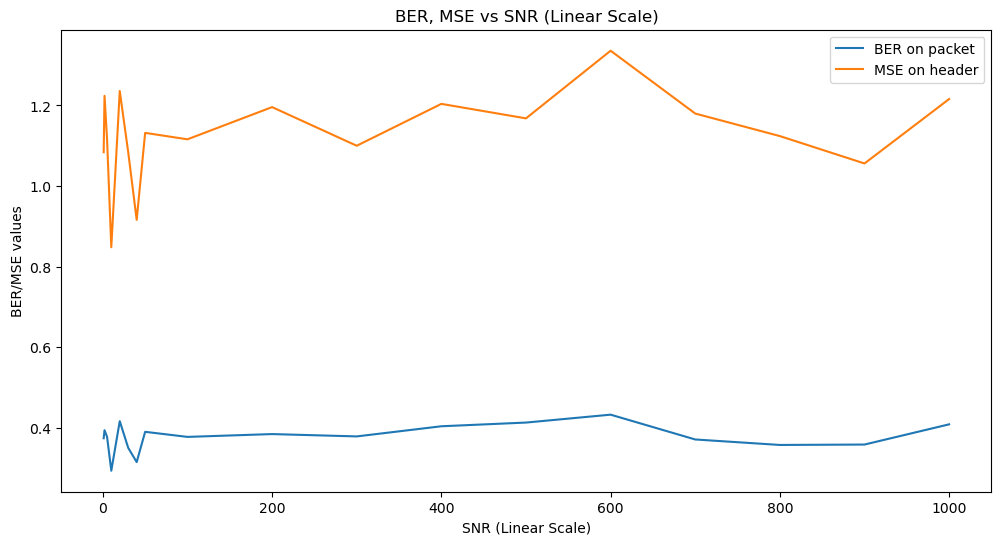

In [519]:
#Plotting BER/MSE values for SNR
ber_array = []
mse_array = []
snr_range = np.array([1, 2, 5, 10, 20, 30, 40, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000])
for i in snr_range:
    original_x, y, estimated_x, just_h_y, h_estimates, actual_h = channel_estimation(packet_size, num_packets, header_size,10*np.log10(i) ,velocity, carrier_frequency)
    non_header_ber = calculate_non_header_ber(original_x, estimated_x, packet_size, header_size)
    ber_array.append(non_header_ber)
    header_mse = calculate_header_mse(original_x, estimated_x, packet_size, header_size)
    mse_array.append(header_mse)
plt.figure(figsize = (12,6))
plt.plot(snr_range, ber_array, label = "BER on packet")
plt.plot(snr_range, mse_array, label = "MSE on header")
plt.legend()
plt.title("BER, MSE vs SNR (Linear Scale)")
plt.xlabel("SNR (Linear Scale)")
plt.ylabel("BER/MSE values")